# FINM 359000 Macro Finance
## Problem Set 2
### Group Members:
- Hongsen (Henry) Fu
- Huayu (Alaia) Zhu
- Mange (Kevin) He
- Yuxuan (Ryan) Bai

# Import Necessary Libraries

In [133]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import datetime
import warnings
import yfinance as yf
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import kpss, adfuller
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.arima import AutoARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import statsmodels.api as sm

In [226]:
def fetch_data_from_FRED(api_key, series_id, file_type, start_date):
    '''
    This function will fetch the bond data given the api key, series id, file type, and start date
    '''

    url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type={file_type}&observation_start={start_date}"

    # Make the API request
    response = requests.get(url)

    if response.status_code == 200:
        # Extract data if the request is successful
        data_raw = response.json()
        observations = data_raw['observations']

        # Convert the data into a list of dictionaries (date and value pairs)
        data = [{'date': entry['date'], 'value': entry['value']} for entry in observations]

        # Create a DataFrame and clean the data
        data_df = pd.DataFrame(data)
        data_df['date'] = pd.to_datetime(data_df['date'])
        data_df['value'] = pd.to_numeric(data_df['value'], errors='coerce')  # Convert values to numeric, making non-numeric into NaN
        data_df = data_df.dropna()  # Remove rows with NaN values

        return data_df
    else:
        print('Failed to retrieve data:', response.status_code)
        return pd.DataFrame()  # Return an empty DataFrame if the request fails

# Macro Regimes

## 4. Choose two different 1 macro variable data series you can get monthly data on that you think matter for macro asset prices. Choose series that have data available since at least 1995 (you may look back further and will learn more in what follows if you do). Why do you think they matter for macro asset prices, and how? (Be explicit, e.g., “when X happens to variable Y, I would expect asset price Z to go in direction Q”.)

In [227]:
SPX_divd = pd.read_excel('data_total_return.xlsx', sheet_name='SPXT')
SPX_divd = SPX_divd.set_index('Date')
SPX_divd.index = pd.to_datetime(SPX_divd.index)
SPX_divd.head()

,Last Price
Date,
2024-05-07,11283.96
2024-04-30,10951.66
2024-03-29,11418.03
2024-02-29,11062.11
2024-01-31,10501.38


In [228]:
SPX_divd_df = pd.read_excel('data_total_return.xlsx', sheet_name='SPXT')
SPX_divd_df = SPX_divd_df.set_index('Date')
SPX_divd_df.index = pd.to_datetime(SPX_divd_df.index)
SPX_divd_df.head()

,Last Price
Date,
2024-05-07,11283.96
2024-04-30,10951.66
2024-03-29,11418.03
2024-02-29,11062.11
2024-01-31,10501.38


In [229]:
from fredapi import Fred
fred = Fred(api_key='cf4f0867024084f82351267f25f9d1c6')
unrate_series = fred.get_series('UNRATE', observation_start='1995-01-01') # 'UNRATE' is the FRED code for U.S. Civilian Unemployment Rate
print(unrate_series.head())

1995-01-01    5.6
1995-02-01    5.4
1995-03-01    5.4
1995-04-01    5.8
1995-05-01    5.6
dtype: float64


In [ ]:
df_manufacturing = fetch_data_from_FRED("cf4f0867024084f82351267f25f9d1c6", "AMTMNO", 'json', start_date ='1995-01-01').set_index('date')

## 5. Define macro regimes since 1995 using these data series. Characterize the regimes and be explicit about dates.

**Solution**: to answer this question, we will consider use K-means Clustering algorithm.

- K-means clustering is employed to segment the dataset into distinct groups based on inherent similarities in the data, which in this case are the economic indicators such as manufacturing output and unemployment rates. 
- The key reason for using K-means in economic analysis is its effectiveness in identifying hidden patterns and structures within complex datasets, which might not be immediately apparent. 
- By grouping data into clusters, K-means helps to reveal different economic regimes, such as periods of expansion, recession, or recovery. 
- This method simplifies the multidimensional data into easily interpretable groups, allowing us to quantitatively distinguish between various macroeconomic conditions based on concrete statistical criteria. 
- After employing K-means, we will likely to get groups of data with clear cutoff for different economic regimes,

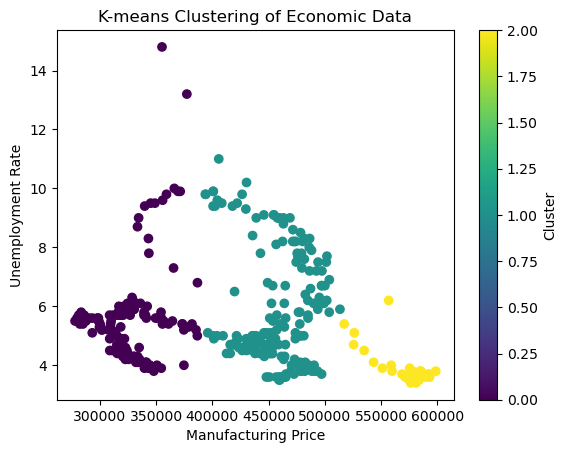

In [211]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# create dataframe that contains the unrate and manufaturing price
data_man_unrate = {
    'Unemployment Rate': unrate_series,
    'Manufacturing Price': df_manufacturing['value']
}
data_man_unrate = pd.DataFrame(data_man_unrate)
data_man_unrate = data_man_unrate.dropna()

X = data_man_unrate

# Fit K-means
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
data_man_unrate['Cluster'] = kmeans.labels_

# Plotting
plt.scatter(data_man_unrate['Manufacturing Price'], data_man_unrate['Unemployment Rate'], c=data_man_unrate['Cluster'], cmap='viridis')
plt.xlabel('Manufacturing Price')
plt.ylabel('Unemployment Rate')
plt.title('K-means Clustering of Economic Data')
plt.colorbar(label='Cluster')
plt.show()


From the plot above, we can tell:
- The K-means clustering visualization of economic data, with unemployment rate plotted against manufacturing output, distinctly categorizes the data into three clusters, each representing a different economic condition. 
- The purple cluster, associated with higher unemployment rates and lower manufacturing outputs, likely indicates periods of economic slowdown or recession. 
- The teal cluster, featuring moderate values of both metrics, suggests phases of economic stability or recovery. 
- Lastly, the yellow cluster, which corresponds to lower unemployment rates and higher manufacturing outputs, points to periods of robust economic expansion. 
- This clustering helps to visualize the cyclical nature of the economy, displaying how periods of growth and contraction are reflected in key economic indicators.

Next, we will plot time against unemployment rate and manufacture price to observe any clear cutoff for economic regimes.

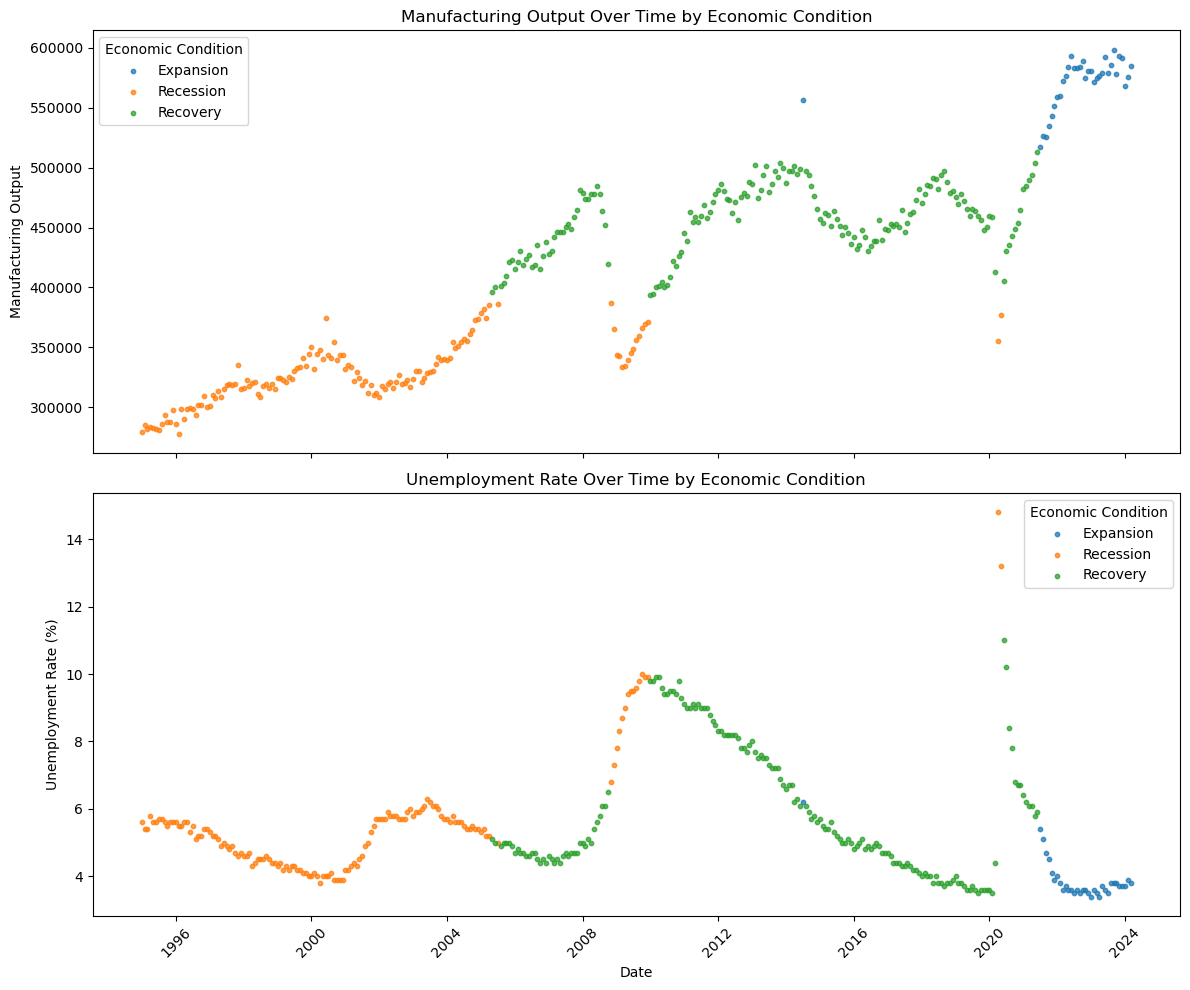

In [232]:
cluster_labels = {
    0: 'Recession',   # Assuming cluster 0 corresponds to recession
    1: 'Recovery',    # Assuming cluster 1 corresponds to recovery
    2: 'Expansion'    # Assuming cluster 2 corresponds to expansion
}

# Map the clusters to these labels in your DataFrame
data_man_unrate['Economic Condition'] = data_man_unrate['Cluster'].map(cluster_labels)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

# Plot Manufacturing vs. Date colored by Cluster
for label, group in data_man_unrate.groupby('Economic Condition'):
    axes[0].scatter(group.index, group['Manufacturing Price'], label=label, s=10, alpha=0.75)  # Adjust size and alpha as needed

axes[0].set_title('Manufacturing Output Over Time by Economic Condition')
axes[0].set_ylabel('Manufacturing Output')
axes[0].legend(title='Economic Condition')  # Adding legend

# Plot Unemployment Rate vs. Date colored by Cluster
for label, group in data_man_unrate.groupby('Economic Condition'):
    axes[1].scatter(group.index, group['Unemployment Rate'], label=label, s=10, alpha=0.75)  # Adjust size and alpha as needed

axes[1].set_title('Unemployment Rate Over Time by Economic Condition')
axes[1].set_ylabel('Unemployment Rate (%)')
axes[1].set_xlabel('Date')
axes[1].legend(title='Economic Condition')  # Adding legend

plt.xticks(rotation=45)  # Rotate date labels for better visibility
plt.tight_layout()
plt.show()


Based on the plot, we can infer:
- There are obvious cutoff for '2009-12-01' and '2021-06-01' (dates extracted by the codes below) which seperate the three macro regimes we defined earlier.
- Start from 2000, unemployment rate increases and manufacturing index drops.
- Unemployment rate increases and manufacturing drops drastically starting from 2008 financial crisis.
- After the first cutoff, economic start recovering, which indicated by the recovery period.
- There are significant peaks for unemployment rate and downside peak for manufacturing price, which reflects severe economic situation during COVID.

In conclusion, the clustering and cutoff reflects on the general economic regimes.

Here we make an assumption: for purple cluster (economic recession), we will include the part that was marked teal (economic recovery) by K-means, this is because after 2008, the unemployment rate increases while manufacture price index drops, which is a significant sign of ecnomic recession. 

In [222]:
# get the date for the cutoff between first and second macro regime
print(data_man_unrate[data_man_unrate['Cluster']==0].tail(10))
first_cutoff = '2009-12-01'

            Unemployment Rate  Manufacturing Price  Cluster
2009-05-01                9.4             339817.0        0
2009-06-01                9.5             345129.0        0
2009-07-01                9.5             348909.0        0
2009-08-01                9.6             355776.0        0
2009-09-01                9.8             359189.0        0
2009-10-01               10.0             366143.0        0
2009-11-01                9.9             369445.0        0
2009-12-01                9.9             371392.0        0
2020-04-01               14.8             355226.0        0
2020-05-01               13.2             377305.0        0


As we can see from the last 10 values of cluster 0 (economic recession), we can set the first cutoff between economic recession and economic recovery to be '2009-12-01'.

In [225]:
# get the date for the cutoff between second and third macro regime
print(data_man_unrate[data_man_unrate['Cluster']==1].tail(5))
second_cutoff = '2021-06-01'


            Unemployment Rate  Manufacturing Price  Cluster
2021-02-01                6.2             484865.0        1
2021-03-01                6.1             490016.0        1
2021-04-01                6.1             493792.0        1
2021-05-01                5.8             503868.0        1
2021-06-01                5.9             513395.0        1
